<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINNs_wave_eq_experimentation2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [ ]:
# install devito
!pip install devito &> /dev/null

In [ ]:
# import libraries and tools
import numpy as np
rng = np.random.default_rng()

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Cloning into 'MScDataSci_21-22'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 386 (delta 119), reused 29 (delta 17), pack-reused 188
Receiving objects: 100% (386/386), 12.94 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (234/234), done.


device(type='cuda', index=0)

## General definition

In [ ]:
xLimit_m = 1.e3 ### METRES ###
zLimit_m = 1.e3 ### METRES ###
tLimit_s = 0.5 ### SECONDS ###

## Devito

In [ ]:
nx = 200 ### NODES ###
nz = 200 ### NODES ###

absorbingLayer = 10 ### NODES ###

dx = xLimit_m / (nx-1) ### METRES ###
dz = zLimit_m / (nz-1) ### METRES ###

xRange = np.arange(0, nx*dx, dx)
zRange = np.arange(0, nz*dz, dz)
xGrid, zGrid = np.meshgrid(xRange, zRange)

origin = (0., 0.)
spacing = (dx, dz)
shape = (nx, nz)

v = np.ones(shape, dtype=np.float32) ### KM/s ###

devitoModel = Model(vp=v,
                    origin=origin,
                    shape=shape,
                    spacing=spacing,
                    space_order=2,
                    nbl=absorbingLayer,
                    bcs='damp',
                    )

dt = devitoModel.critical_dt
tLimit_ms = tLimit_s * 1e3 ### MILLISECONDS ###
nt = tLimit_ms / dt
timeRange = TimeAxis(start=0, stop=tLimit_ms, step=dt)

u = TimeFunction(name='u',
                 grid=devitoModel.grid,
                 time_order=2,
                 space_order=2,
                 save=int(nt)+2,
                 )

pde = devitoModel.m * u.dt2 - u.laplace + devitoModel.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

f0 = 0.01 ### kHZ ###
source = RickerSource(name='src',
                      grid=devitoModel.grid,
                      f0=f0,
                      npoint=1,
                      time_range=timeRange,
                      )

source.coordinates.data[0, 0] = int(xLimit_m*0.5) ### METRES ###
source.coordinates.data[0, 1] = int(zLimit_m*0.25) ### METRES ###

sourceTerm = source.inject(field=u.forward, expr=source * dt**2 / devitoModel.m)

op = Operator([stencil] + sourceTerm, subs=devitoModel.spacing_map)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


# Define medium

In [ ]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

FD_solutionWithSrc = np.array(u.data[:,
                              absorbingLayer:u.data.shape[1]-absorbingLayer,
                              absorbingLayer:u.data.shape[2]-absorbingLayer
                              ])
FD_solutionWithSrc.shape

Operator `Kernel` ran in 0.03 s
INFO:Devito:Operator `Kernel` ran in 0.03 s


Training duration: 0.81s


(164, 200, 200)

# PINN

PDE loss term is 20,000 points  
while 3,600 points are set for each of the early-time snapshot data

NsxArray consists of Nsx randomly sampled points from time sx (t, x, z, u)

In [ ]:
# define physics informed neural network for 1D Burgers' equation
class PINN_2D_AcousticWave(torch.nn.Module):
    def __init__(self,
                 hiddenLayers,
                 nodesPerLayer,
                 activationFunction,
                 uTrain,
                 uTrainDeltas,
                 maxArray,
                 NuTotal,
                 NfTotal,
                 trainingResample,
                 NuRange,
                 maxIterations,
                 maxEvaluations,
                 l1,
                 l2,
                 verbose = True
                 ):
        super(PINN_2D_AcousticWave, self).__init__()
        # network structure
        self.layers = torch.nn.ModuleList()
        self.activationFunction = activationFunction
        # input layer
        self.layers.append(torch.nn.Linear(3, nodesPerLayer))
        # hidden layers
        for _ in range(hiddenLayers):
            self.layers.append(torch.nn.Linear(nodesPerLayer, nodesPerLayer))
        # output layer
        self.layers.append(torch.nn.Linear(nodesPerLayer, 1))

        self.uTrain = uTrain
        self.uTrainDeltas = uTrainDeltas

        self.maxArray = maxArray
        self.maxArray[-1] = uTrain.max()
        
        self.NuTotal = NuTotal
        self.NfTotal = NfTotal

        self.trainingResample = trainingResample
        self.NuRange = NuRange

        self.l1 = l1
        self.l2 = l2

        self.history = np.empty((0,3), float)        

        # boolean whether to print update during training
        self.verbose = verbose

        self.AdamOptimiser = torch.optim.Adam(
            self.parameters(),
            lr=1.e-3, # default lr=0.001, 
            )

        # define L-BFGS optimiser
        self.LBFGS_optimiser = torch.optim.LBFGS(
            self.parameters(),
            max_iter=maxIterations,
            max_eval=maxEvaluations,
            tolerance_change= 1.0 * np.finfo(float).eps,
            line_search_fn='strong_wolfe',
            )

    def createNf(self, tLim):
        # create collocation training points selected uniformly randomly across input domain: t - x - z
        # Nf = np.array([
        #     rng.uniform(0, tLim, self.NfTotal),
        #     rng.uniform(0, self.maxArray[1], self.NfTotal),
        #     rng.uniform(0, self.maxArray[2], self.NfTotal),
        #     ]).T

        # normalise
        # Nf = 2 * Nf / self.maxArray[:-1] - 1

        Nf = np.array([
            rng.uniform(-1, 1, self.NfTotal),
            rng.uniform(-1, 1, self.NfTotal),
            rng.uniform(-1, 1, self.NfTotal),
        ]).T

        return torch.from_numpy(Nf.astype(np.float32)).requires_grad_().to(device)

    def createNu(self):
        if self.NuRange:
            Nu = np.array([
                rng.choice(self.uTrain.shape[0], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[1], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[2], self.NuTotal, replace=True),
                np.zeros(self.NuTotal)
                ]).astype(float).T
            Nu[:,3] = self.uTrain[
                Nu[:,0].astype(int),
                Nu[:,1].astype(int),
                Nu[:,2].astype(int)]
            Nu[:,:3] *= self.uTrainDeltas
        else:
            N = int(self.NuTotal*0.5)
            Nu1 = np.array([
                        np.zeros(N),
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu1[:,3] = self.uTrain[0][
                            Nu1[:,1].astype(int),
                            Nu1[:,2].astype(int)]
            Nu1[:,:3] *= self.uTrainDeltas
            Nu2 = np.array([
                        np.ones(N) * self.uTrain.shape[0],
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu2[:,3] = self.uTrain[-1][
                                Nu2[:,1].astype(int),
                                Nu2[:,2].astype(int)]
            Nu2[:,:3] *= self.uTrainDeltas

            Nu = np.concatenate([Nu1, Nu2])

        # normalise
        Nu = 2 * Nu / self.maxArray - 1

        return torch.from_numpy(Nu[:,:-1].astype(np.float32)).requires_grad_().to(device),\
                    torch.from_numpy(Nu[:,-1].astype(np.float32)).to(device)

    # compute solution via forward pass
    def forward(self, X):
        input = X
        for layer in self.layers[:-1]:
            input = self.activationFunction(layer(input))
        return self.layers[-1](input).flatten()

    # compute PDE residual
    def residual(self, X):

        # u = self.forward(t, x, z).flatten()
        # # compute derivatives
        # ut = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        # utt = torch.autograd.grad(ut, t, torch.ones_like(ut), create_graph=True)[0]
        # ux = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0] 
        # uxx = torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0]
        # uz = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0] 
        # uzz = torch.autograd.grad(uz, z, torch.ones_like(uz), create_graph=True)[0]
        # # if inverse compute l2 value from natural log of l2
        # # if self.inverseProblem:
        # #     self.l2 = torch.exp(self.l2_exp)
        
        # m = self.medium(x, z)
        # # compute PDE residual
        # # return m * utt - (uxx + uzz) # + f
        # return utt - m**2 * (uxx + uzz) #+ f

        t = X[:,0].clone()
        x = X[:,1].clone()
        z = X[:,2].clone()
        X = torch.stack((t,x,z)).T
        # compute solution
        u = self.forward(X)#.flatten()

        # du_dNf = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]

        du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        du_dz = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0]

        d2u_dt2 = torch.autograd.grad(du_dt, t, torch.ones_like(du_dt), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
        d2u_dz2 = torch.autograd.grad(du_dz, z, torch.ones_like(du_dz), create_graph=True)[0]

        # d2u_dt2 = torch.autograd.grad(du_dNf[:,0], t, torch.ones_like(u), create_graph=True)[0]
        # d2u_dx2 = torch.autograd.grad(du_dNf[:,1], x, torch.ones_like(u), create_graph=True)[0]
        # d2u_dz2 = torch.autograd.grad(du_dNf[:,2], z, torch.ones_like(u), create_graph=True)[0]

        # print(d2u_dt2.shape)
        # print(d2u_dx2.shape)
        # print(d2u_dz2.shape)

        # compute PDE residual
        return d2u_dt2 - (d2u_dx2 + d2u_dz2)

    def lossFunc(self, Nu_pred, Nu_targ, Nf_r):
        self.iterationCount += 1
        # compute constituent loss components
        NuLoss = torch.mean(torch.square(Nu_pred - Nu_targ))
        # if Nf_r != None:
        # print(Nf_r.shape)
        NfLoss = torch.mean(torch.square(Nf_r))
        # else:
        #     NfLoss = torch.tensor([0.]).to(device)
        totalLoss = self.l2*NuLoss + self.l1*NfLoss
        # totalLoss = self.l2*NuLoss
        # store losses
        self.history = np.append(self.history,
                                 np.array([
                                           [totalLoss.item()],
                                           [NuLoss.item()],
                                           [NfLoss.item()],
                                           ]).T,
                                 axis=0)
        # print training progress update (every (2**2)th epoch initially, then every 1000th)
        if self.verbose and ((np.log2(self.iterationCount) % 1 == 0 and self.iterationCount < 1000) or self.iterationCount % 1000 == 0):
            seconds = perf_counter() - self.startTime
            print(f'Epoch: {self.iterationCount} --- Elapsed time: {int(seconds/60)}m{int(seconds%60)}s --- Loss: {self.history[-1,0]}')
        return totalLoss

    def Adam_trainer(self, epochs, epochsNuOnly):
        self.train()
        self.iterationCount = 0
        self.startTime = perf_counter()

        tLim = self.maxArray[0]

        Nf = self.createNf(tLim)
        Nu, Nu_targ = self.createNu()

        for epoch in range(epochs):
            self.AdamOptimiser.zero_grad()
            Nu_pred = self.forward(Nu)

            if epoch > epochsNuOnly:
                Nf_r = self.residual(Nf)
            else:
                Nf_r = torch.tensor([0.]).to(device)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)
            lossValue.backward()
            self.AdamOptimiser.step()
            if self.trainingResample:
                Nf = self.createNf(tLim)
                Nu, Nu_targ = self.createNu()
        self.eval()
    
    def LBFGS_trainer(self):
        # set to train mode
        self.train()
        # initialise variables to track progress
        self.iterationCount = 0
        self.startTime = perf_counter()
        # Prepare training tensors
        tLim = self.maxArray[0]

        Nf = self.createNf(tLim)
        Nu, Nu_targ = self.createNu()

        # define closure function for L-BFGS optimiser
        def closure():
            # if self.trainingResample:
            #     Nf = self.createNf(tLim)
            #     Nu, Nu_targ = self.createNu()
            self.LBFGS_optimiser.zero_grad()
            Nu_pred = self.forward(Nu)
            Nf_r = self.residual(Nf)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)
            lossValue.backward()
            return lossValue
        # run optimiser
        self.LBFGS_optimiser.step(closure)
        # training complete, set to evaluation mode
        self.eval()

    def generateOutput(self):

        t = np.arange(0, self.maxArray[0] + 2*self.uTrainDeltas[0], self.uTrainDeltas[0])
        x = np.arange(0, self.maxArray[1] + self.uTrainDeltas[1], self.uTrainDeltas[1])
        z = np.arange(0, self.maxArray[2] + self.uTrainDeltas[2], self.uTrainDeltas[2])

        T, X, Z = np.meshgrid(t, x, z, indexing='ij')

        N = np.stack((T.flatten(), X.flatten(), Z.flatten())).T

        N = 2 * N / self.maxArray[:-1] - 1

        U = self.forward(torch.from_numpy(N.astype(np.float32)).to(device)).cpu().detach().numpy()

        U = (U + 1.) * self.maxArray[-1] * 0.5

        return np.reshape(U, (t.shape[0], x.shape[0], z.shape[0]))

In [ ]:
# define network characteristics
hiddenLayers = 4
nodesPerLayer = 40
activationFunction = nn.Tanh()

uTrainSlices = 10
sourceEndTime = 2/f0 ### MILLISECONDS ###
fdSliceStart = int(sourceEndTime/dt)
FD_solution = FD_solutionWithSrc[fdSliceStart:]

uTrain = FD_solution[:uTrainSlices]

uTrainDeltas = np.array([
    dt*1e-3,
    dx,
    dz,])
maxArray = np.array([
    (tLimit_ms - sourceEndTime) * 1e-3,
    xLimit_m,
    zLimit_m,
    0.,])

NuTotal = 6000
NfTotal = 8000
trainingResample = False
NuRange = False
maxIterations = 50000
maxEvaluations = 50000
l1 = 0.1 # residual (PDE)
l2 = 1. # snapshots

model = PINN_2D_AcousticWave(hiddenLayers, nodesPerLayer, activationFunction,
                             uTrain, uTrainDeltas, maxArray,
                             NuTotal, NfTotal,
                             trainingResample, NuRange,
                             maxIterations, maxEvaluations,
                             l1, l2)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

model = model.to(device)

Network parameters: 6761


In [ ]:
model.LBFGS_trainer()
# model.Adam_trainer(10000, 10000)

Epoch: 1 --- Elapsed time: 0m0s --- Loss: 0.8835082650184631
Epoch: 2 --- Elapsed time: 0m0s --- Loss: 0.7904660701751709
Epoch: 4 --- Elapsed time: 0m0s --- Loss: 0.12240533530712128
Epoch: 8 --- Elapsed time: 0m0s --- Loss: 0.06125836819410324
Epoch: 16 --- Elapsed time: 0m0s --- Loss: 0.05937182530760765
Epoch: 32 --- Elapsed time: 0m1s --- Loss: 0.05926019325852394
Epoch: 64 --- Elapsed time: 0m2s --- Loss: 0.059183984994888306
Epoch: 128 --- Elapsed time: 0m5s --- Loss: 0.059065353125333786
Epoch: 256 --- Elapsed time: 0m11s --- Loss: 0.059002622961997986
Epoch: 512 --- Elapsed time: 0m23s --- Loss: 0.0588817298412323
Epoch: 1000 --- Elapsed time: 0m46s --- Loss: 0.05856179818511009
Epoch: 2000 --- Elapsed time: 1m34s --- Loss: 0.05781148001551628
Epoch: 3000 --- Elapsed time: 2m25s --- Loss: 0.05625898763537407


KeyboardInterrupt: ignored

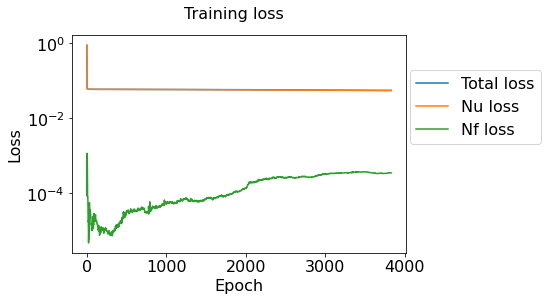

In [ ]:
fig = utilityFunctions.trainingHistoryPlot(model.history,
                                           ['Total loss', 'Nu loss', 'Nf loss'],
                                           'Loss',
                                           'Training loss',
                                           yLogAx=True,
                                           )

In [ ]:
PINN_solution = model.generateOutput()

## Plots
Compute u from PINN for all t, x, z in same results form as Devito (np array: t-z-x)

Training data up to 0.03s


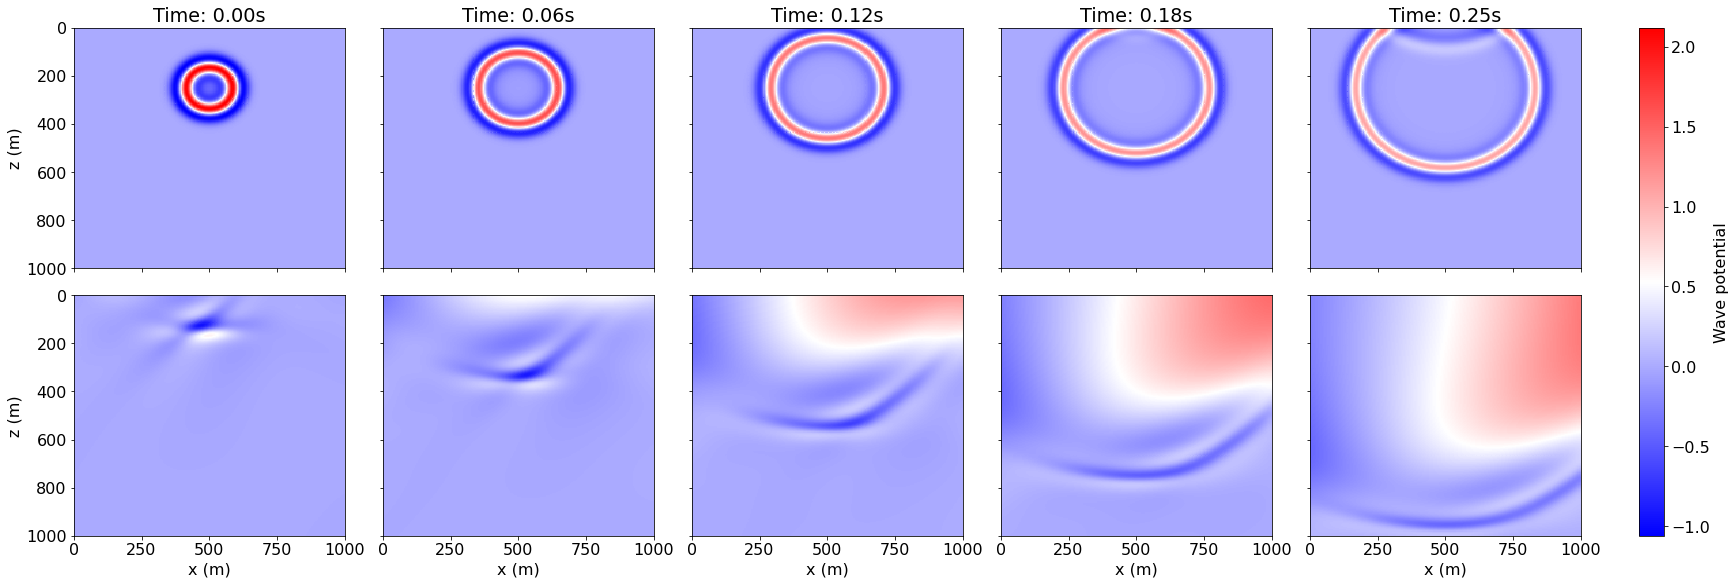

In [ ]:
numPlots = 5

norm = matplotlib.colors.Normalize(min(FD_solution.min(), PINN_solution.min()), max(FD_solution.max(), PINN_solution.max()))
cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, axs = plt.subplots(2, numPlots,
                        figsize=(24, 8),
                        constrained_layout=True,
                        sharex=True,
                        sharey=True,
                        )
axs[0,0].invert_yaxis()

for idx, ax in enumerate(axs[0]):
    plot = ax.pcolormesh(xGrid, zGrid, FD_solution[idx * int(FD_solution.shape[0]/numPlots)].T, norm=norm, cmap='bwr')
    if idx == 0:
        ax.set_ylabel('z (m)')
    ax.set_title(f'Time: {(uTrainDeltas[0] * idx * int(FD_solution.shape[0]/numPlots)):.2f}s')
for idx, ax in enumerate(axs[1]):    
    plot = ax.pcolormesh(xGrid, zGrid, PINN_solution[idx * int(PINN_solution.shape[0]/numPlots)].T, cmap='bwr', norm=norm)
    ax.set_xlabel('x (m)')
    if idx == 0:
        ax.set_ylabel('z (m)')
clb = fig.colorbar(mapping, ax=axs.ravel(), aspect=60)
clb.set_label('Wave potential')

print(f'Training data up to {(uTrainDeltas[0] * uTrainSlices):.2f}s')

plt.show()

In [ ]:
np.linalg.norm(FD_solution-PINN_solution) / np.linalg.norm(FD_solution)

1.0970076

In [ ]:
        # # Prepare training tensors
        # tLim = self.maxArray[0]

        # Nf = self.createNf(tLim)
        # Nu, Nu_targ = self.createNu()

tLim = maxArray[0]
tLim

0.3

In [ ]:
Nu, Nu_targ = model.createNu()#tLim)

In [ ]:
Nu[:,2].min()

tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)